In [62]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [63]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight
from sklearn.cross_validation import train_test_split

In [64]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model

In [65]:
import bundlenet as bn

In [66]:
import dask.bag as db
import warnings
warnings.filterwarnings('ignore')

In [73]:
ls /home/ubuntu/Atlas_80_Bundles/bundles

AC.trk               CNIII_L.trk   CS_R.trk   ICP_L.trk   ML_L.trk   STT_L.trk
AF_L.trk             CNIII_R.trk   CST_L.trk  ICP_R.trk   ML_R.trk   STT_R.trk
AF_R.trk             CNII_L.trk    CST_R.trk  IF0F_R.trk  OPT_L.trk  TPT_L.trk
AR_L.trk             CNII_R.trk    CT_L.trk   IFOF_L.trk  OPT_R.trk  TPT_R.trk
AR_R.trk             CNIV_L.trk    CT_R.trk   IFOF_R.trk  OR_L.trk   UF_L.trk
AST_L.trk            CNIV_R.trk    CTT_L.trk  ILF_L.trk   OR_R.trk   UF_R.trk
AST_R.trk            CNVIII_L.trk  CTT_R.trk  ILF_R.trk   PC.trk     VOF_L.trk
CB_L.trk             CNVIII_R.trk  DLF_L.trk  LL_L.trk    PPT_L.trk  VOF_R.trk
CB_R.trk             CNVII_L.trk   DLF_R.trk  LL_R.trk    PPT_R.trk  V.trk
CC_ForcepsMajor.trk  CNVII_R.trk   EMC_L.trk  MCP.trk     RST_L.trk
CC_ForcepsMinor.trk  CNV_L.trk     EMC_R.trk  MdLF_L.trk  RST_R.trk
CCMid.trk            CNV_R.trk     F_L_R.trk  MdLF_R.trk  SCP.trk
CC.trk               C_R.trk       FPT_L.trk  MLF_L.trk   SLF_L.trk
C_L.trk              CS_L

In [105]:
bundles80 = ['AC', 'CS','CST','CT','F','FPT','OPT','OR','PPT','TPT','AF','C','EMC','FAT','IFOF','ILF'\
            'MdLF', 'SLF', 'U', 'UF', 'VOF', 'CC_ForcepsMajor','CC_ForcepsMinor','CCMid']

In [107]:
bundle_files = []
for b in bundles80:
    bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/' + b + '_R.trk')
for b in bundles80:
    bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/' + b + '_L.trk')

In [101]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_80_Bundles/bundles/*trk'))

In [ ]:
#bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))

In [80]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [108]:
bundle_files

['/home/ubuntu/Atlas_80_Bundles/bundles/AC_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/CS_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/CST_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/CT_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/F_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/FPT_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/OPT_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/OR_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/PPT_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/TPT_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/AF_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/C_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/EMC_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/FAT_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/IFOF_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/ILFMdLF_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/SLF_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/U_R.trk',
 '/home/ubuntu/Atlas_80_Bundles/bundles/UF_R.trk',
 '/home/ubuntu/Atla

In [89]:
del(bundle_files)

In [10]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))


In [11]:
np.min(n_streamlines), len(n_streamlines)

(72, 16)

In [12]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0
val_perc=0.2
size_slimage = 100
dil_iters = 5

In [14]:
process_sl = 0

if process_sl == 1:
    streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
    streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage,dil_iters).compute() 
    data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)
    plt.imshow(streamlines_processed[5][1,:,:,0])

In [15]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 16
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [18]:
fit_model = 0

if fit_model == 0:
    model = load_model('savedmodel'+ num_classes +'.h5')
    model.load_weights('checkpoints/weights.best' + num_classes + '.hdf5')
else:
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels_train),
                                                 labels_train)
    model = bn.buildmodel(input_shape,num_classes)
    labels_train = keras.utils.to_categorical(labels_train, num_classes)
    labels_test  = keras.utils.to_categorical(labels_test, num_classes)
    labels_val  = keras.utils.to_categorical(labels_val, num_classes)
    filepath='checkpoints/weights.best' + num_classes + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val),
                     callbacks=callbacks_list,
                     class_weight=class_weights)
    model.save('savedmodel'+ num_classes +'.h5')
    fig = bn.plot_accuracy(training)

In [19]:
sub2_t1_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape_subj2=sub2_t1_img.shape[0:3]
vol_shape_subj2

(182, 218, 182)

In [20]:
# if op.exists('./streamlines_processed_100307.npz'):
#     loaded_from_file = np.load('streamlines_processed_100307.npz')
#     streamlines_all_processed_subj1 = loaded_from_file['processed_streamlines']
#     labels_selected_s1 = loaded_from_file['streamline_labels']
# else:
#     streamlines_all_s1 = bn.read_sl_mni('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
#     map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
#     labeled_index_s1, labels_s1 = bn.getlabeledstreamlines(map_files)
#     unlabeled_index_s1 = bn.getunlabeledstreamlines(len(streamlines_all_s1), labeled_index_s1, len(streamlines_all_s1)-len(labeled_index_s1), 0)
#     labels_selected_s1, streamlines_selected_s1 = bn.combinestreamlines(labeled_index_s1, unlabeled_index_s1, labels_s1, streamlines_all_s1)
#     streamlines_all_processed_subj1 = bn.process_sl(streamlines_selected_s1,-1,vol_shape_subj2,size_slimage,dil_iters)
#     np.savez('streamlines_processed_100307',processed_streamlines = streamlines_all_processed_subj1, streamline_labels = labels_selected_s1)

In [21]:
if op.exists('./p_subj1.npz'):
    loaded_from_file = np.load('p_subj1.npz')
    labels_selected_s1 = loaded_from_file['labels']
    p_subj1 = loaded_from_file['p']
    p_idx_s1 = np.argmax(p_subj1, axis=-1)
else:
    p_subj1 = model.predict(streamlines_all_processed_subj1, batch_size=5)
    p_idx_s1 = np.argmax(p_subj1, axis=-1)
    np.savez('p_subj1.npz',p=p_subj1,labels=labels_selected_s1)

In [22]:
bn.print_accuarcystats(p_idx_s1[labels_selected_s1<16],labels_selected_s1[labels_selected_s1<16])

Percent correct is 0.9896141916146796 
Kappa is: 0.9874508479077824
Jaccard is: 0.9896141916146796


In [23]:
X_train, X_test, y_train, y_test = train_test_split(p_subj1,labels_selected_s1, test_size=0.2, random_state=42, stratify=labels_selected_s1)
#make binary labels
y_train_2class = y_train.copy()
y_train_2class[y_train<16] = 0
y_train_2class[y_train==16] = 1
y_test_2class = y_test.copy()
y_test_2class[y_test<16] = 0
y_test_2class[y_test==16] = 1
p_2class_s1 = bn.run_xgboost(X_train,y_train_2class,X_test,y_test_2class,10,2,0.9)

0.989022477783586

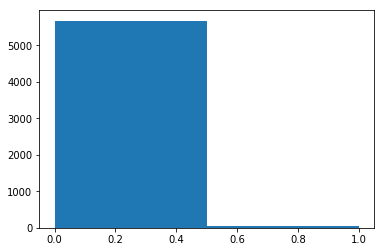

In [25]:
targ_val=0
ind=y_test_2class==targ_val
plt.hist(p_2class_s1[ind],bins=2)
perc_correct_2class = np.sum(p_2class_s1[ind]==targ_val)/np.sum(ind)
perc_correct_2class

In [ ]:
# if op.exists('./streamlines_processed_100408.npz'):
#     loaded_from_file = np.load('streamlines_processed_100408.npz')
#     streamlines_all_processed_subj2 = loaded_from_file['processed_streamlines']
#     labels_selected_s2 = loaded_from_file['streamline_labels']
# else:
#     streamlines_all_s2 = bn.read_sl_mni('/home/ubuntu/recobundles/100408/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
#     map_files = sorted(glob('/home/ubuntu/recobundles/100408/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
#     labeled_index_s2, labels_s2 = bn.getlabeledstreamlines(map_files)
#     unlabeled_index_s2 = bn.getunlabeledstreamlines(len(streamlines_all_s2), labeled_index_s2, len(streamlines_all_s2)-len(labeled_index_s2), 0)
#     labels_selected_s2, streamlines_selected_s2 = bn.combinestreamlines(labeled_index_s2, unlabeled_index_s2, labels_s2, streamlines_all_s2)
#     streamlines_all_processed_subj2 = bn.process_sl(streamlines_selected_s2,-1,vol_shape_subj2,size_slimage,dil_iters)
#     np.savez('streamlines_processed_100408',processed_streamlines = streamlines_all_processed_subj2, streamline_labels = labels_selected_s2)

In [28]:
if op.exists('./p_subj2.npz'):
    loaded_from_file = np.load('p_subj2.npz')
    labels_selected_s2 = loaded_from_file['labels']
    p_subj2 = loaded_from_file['p']
    p_idx_s2 = np.argmax(p_subj2, axis=-1)
else:
    p_subj2 = model.predict(streamlines_all_processed_subj2, batch_size=5)
    p_idx_s2 = np.argmax(p_subj2, axis=-1)
    np.savez('p_subj2.npz',p=p_subj2,labels=labels_selected_s2)

In [29]:
bn.print_accuarcystats(p_idx_s2[labels_selected_s2<16],labels_selected_s2[labels_selected_s2<16])

Percent correct is 0.9682636402874045 
Kappa is: 0.9621449743831764
Jaccard is: 0.9682636402874045


In [ ]:
# if op.exists('./streamlines_processed_987074.npz'):
#     loaded_from_file = np.load('streamlines_processed_987074.npz')
#     streamlines_all_processed_subj3 = loaded_from_file['processed_streamlines']
#     labels_selected_s3 = loaded_from_file['streamline_labels']
# else:
#     streamlines_all_s3 = bn.read_sl_mni('/home/ubuntu/recobundles/987074/dwi/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
#     print(len(streamlines_all_s3))
#     map_files = sorted(glob('/home/ubuntu/recobundles/987074/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
#     labeled_index_s3, labels_s3 = bn.getlabeledstreamlines(map_files)
#     unlabeled_index_s3 = bn.getunlabeledstreamlines(len(streamlines_all_s3), labeled_index_s3, len(streamlines_all_s3)-len(labeled_index_s3), 0)
#     labels_selected_s3, streamlines_selected_s3 = bn.combinestreamlines(labeled_index_s3, unlabeled_index_s3, labels_s3, streamlines_all_s3)
#     streamlines_all_processed_subj3 = bn.process_sl(streamlines_selected_s3,-1,vol_shape_subj2,size_slimage,dil_iters)
#     np.savez('streamlines_processed_1987074',processed_streamlines = streamlines_all_processed_subj3, streamline_labels = labels_selected_s3)

In [32]:
if op.exists('./p_subj3.npz'):
    loaded_from_file = np.load('p_subj3.npz')
    labels_selected_s3 = loaded_from_file['labels']
    p_subj3 = loaded_from_file['p']
    p_idx_s3 = np.argmax(p_subj3, axis=-1)
else:
    p_subj3 = model.predict(streamlines_all_processed_subj3, batch_size=5)
    p_idx_s3 = np.argmax(p_subj3, axis=-1)
    np.savez('p_subj3.npz',p=p_subj3,labels=labels_selected_s3)

In [33]:
bn.print_accuarcystats(p_idx_s3[labels_selected_s3<16],labels_selected_s3[labels_selected_s3<16])

Percent correct is 0.982827162830949 
Kappa is: 0.9801163367300226
Jaccard is: 0.982827162830949


In [ ]:
# if op.exists('./streamlines_processed_995174.npz'):
#     loaded_from_file = np.load('streamlines_processed_995174.npz')
#     streamlines_all_processed_subj4 = loaded_from_file['processed_streamlines']
#     labels_selected_s4 = loaded_from_file['streamline_labels']
# else:
#     streamlines_all_s4 = bn.read_sl_mni('/home/ubuntu/recobundles/995174/dwi/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
#     print(len(streamlines_all_s4))
#     map_files = sorted(glob('/home/ubuntu/recobundles/995174/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
#     labeled_index_s4, labels_s4 = bn.getlabeledstreamlines(map_files)
#     unlabeled_index_s4 = bn.getunlabeledstreamlines(len(streamlines_all_s4), labeled_index_s4, len(streamlines_all_s4)-len(labeled_index_s4), 0)
#     labels_selected_s4, streamlines_selected_s4 = bn.combinestreamlines(labeled_index_s4, unlabeled_index_s4, labels_s4, streamlines_all_s4)
#     streamlines_all_processed_subj4 = bn.process_sl(streamlines_selected_s4,-1,vol_shape_subj2,size_slimage,dil_iters)
#     np.savez('streamlines_processed_995174',processed_streamlines = streamlines_all_processed_subj4, streamline_labels = labels_selected_s4)

In [30]:
if op.exists('./p_subj4.npz'):
    loaded_from_file = np.load('p_subj4.npz')
    labels_selected_s4 = loaded_from_file['labels']
    p_subj4 = loaded_from_file['p']
    p_idx_s4 = np.argmax(p_subj4, axis=-1)
else:
    p_subj4 = model.predict(streamlines_all_processed_subj4, batch_size=5)
    p_idx_s4 = np.argmax(p_subj4, axis=-1)
    np.savez('p_subj4.npz',p=p_subj4,labels=labels_selected_s4)

In [34]:
bn.print_accuarcystats(p_idx_s4[labels_selected_s4<16],labels_selected_s4[labels_selected_s4<16])

Percent correct is 0.9801152978527864 
Kappa is: 0.9750997242942505
Jaccard is: 0.9801152978527864


In [ ]:
#p_s2 = bn.run_xgboost(p_subj1,labels_selected_s1,p_subj2,labels_selected_s2,10,17,0)

In [35]:
#make binary labels
labels_selected_s1_2class = labels_selected_s1.copy()
labels_selected_s1_2class[labels_selected_s1_2class<16] = 0
labels_selected_s1_2class[labels_selected_s1_2class==16] = 1
labels_selected_s2_2class = labels_selected_s2.copy()
labels_selected_s2_2class[labels_selected_s2_2class<16] = 0
labels_selected_s2_2class[labels_selected_s2_2class==16] = 1
p_2class_s2 = bn.run_xgboost(p_subj1,labels_selected_s1_2class,p_subj2,labels_selected_s2_2class,10,2,0.95)

In [38]:
labels_selected_s2.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

0.864473049483332

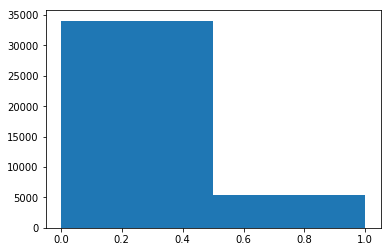

In [37]:
targ_val = 0
ind=labels_selected_s2_2class==targ_val
plt.hist(p_2class_s2[ind],bins=2)
perc_correct_2class = np.sum(p_2class_s2[ind]==targ_val)/np.sum(ind)
perc_correct_2class

In [56]:
#make binary labels
labels_selected_s134_2class = np.concatenate((labels_selected_s1,labels_selected_s3,labels_selected_s4))
labels_selected_s134_2class[labels_selected_s134_2class<16] = 0
labels_selected_s134_2class[labels_selected_s134_2class==16] = 1
labels_selected_s2_2class = labels_selected_s2.copy()
labels_selected_s2_2class[labels_selected_s2_2class<16] = 0
labels_selected_s2_2class[labels_selected_s2_2class==16] = 1
p_subj134 = np.concatenate((p_subj1,p_subj3,p_subj4))
p_2class_s2 = bn.run_xgboost(p_subj134,labels_selected_s134_2class,p_subj2,labels_selected_s2_2class,10,2,0.9)

0.9145911087414629

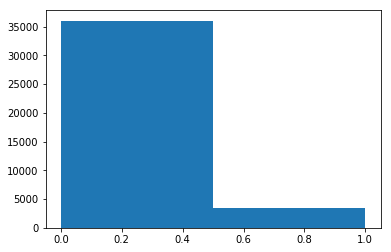

In [58]:
targ_val = 0
ind=labels_selected_s2_2class==targ_val
plt.hist(p_2class_s2[ind],bins=2)
perc_correct_2class = np.sum(p_2class_s2[ind]==targ_val)/np.sum(ind)
perc_correct_2class

In [ ]:
perc_correct = np.zeros((17,1))
nsl = np.zeros((17,1))
for i in range(17):
    ind = labels_selected_s2 == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p_s2[ind]==i)/np.sum(ind)
perc_correct

In [ ]:
p_subj2_withclass = model.predict(streamlines_all_processed_subj2[preds_max<16,:,:,:], batch_size=5)

In [ ]:
l = labels_subj2[preds_max<16]
p_withclass_2 = np.argmax(p_subj2_withclass,axis=1)
perc_correct = np.zeros((16,1))
nsl = np.zeros((16,1))
for i in range(16):
    ind = l == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p_withclass_2[ind]==i)/np.sum(ind)
perc_correct

In [ ]:
imp.reload(bn)
streamlines_all2_nomni = bn.read_sl('/home/ubuntu/recobundles/100408/out_work/whole_brain_MNI_tracks_from_sh__moved.trk')
streamlines_all_nomni_subj2 = [streamlines_all2_nomni[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]

In [ ]:
tmp = np.where(p<16)
t = tmp[0]
classified_streamlines = [streamlines_all_nomni_subj2[i] for i in t ]

In [ ]:
probs = np.max(p_subj2_nounclass,axis=1)

In [ ]:
bundle_names

In [ ]:
imp.reload(bn)
for i, bund in enumerate(bundle_names):
    bn.savesegtrk(classified_streamlines, p_withclass_2, i, probs, 0.9,'TRK/'+bund+'.trk',0)